In [73]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

import numpy as np
from nltk.data import load
import sklearn
from sklearn import svm as SVM
from sklearn.model_selection import GridSearchCV
import nltk
import matplotlib.pyplot as plt
import helper
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('tagsets')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/movieminer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/movieminer/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /home/movieminer/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to /home/movieminer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [74]:
data_path = 'A4data_2324_pan2020/'

def load_data():
    train_dataset = pd.read_csv(data_path + 'pan2324_train_data.csv')
    test_dataset = pd.read_csv(data_path + 'pan2324_test_data.csv')
    dev_dataset = pd.read_csv(data_path + 'pan2324_dev_data.csv')
    return train_dataset, test_dataset, dev_dataset

In [75]:
train_dataset, test_dataset, dev_dataset = load_data()

In [76]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
function_words = helper.function_words

def feature_extraction(dataset):
    text = dataset['text']
    authors = dataset['author']
    features = {}

    # Character based features
    features['CF'] = pd.DataFrame()
    features['LETTERS'] = pd.DataFrame()
    features['CHARS'] = pd.DataFrame()

    features['CF']['char_count'] = text.apply(len)
    uppercase_count = text.apply(lambda x: sum([1 for char in x if char.isupper()]))
    features['CF']['uppercase_frequency'] = uppercase_count / features['CF']['char_count']
    digit_count = text.apply(lambda x: sum([1 for char in x if char.isdigit()]))
    features['CF']['digit_frequency'] = digit_count / features['CF']['char_count']
    features['CF']['whitespace_frequency'] = text.apply(lambda x: sum([1 for char in x if char == ' '])) / features['CF']['char_count']
    features['CF']['alphabet_count'] = text.apply(lambda x: sum([1 for letter in x.lower() if letter.isalpha()]))

    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features['LETTERS'][letter + '_frequency'] = text.apply(lambda x: x.lower().count(letter)) / features['CF']['char_count']
        
    for special_character in ["~" , "@", "#", "$", "%", "^", "&", "*", "-", "_", "=" ,"+", ">", "<", "[", "]", "{", "}", "/", "\\", "|"]:
        features['CHARS'][special_character + '_frequency'] = text.apply(lambda x: x.count(special_character)) / features['CF']['char_count']

    # Word based features
    features['WF'] = pd.DataFrame()

    features['WF']['word_count'] = text.apply(lambda x: len(x.split()))
    features['WF']['avg_word_length'] = text.apply(lambda x: sum([len(word) for word in x.split()]) / len(x.split()))
    features['WF']['avg_sentence_length'] = text.apply(lambda x: sum([len(sentence) for sentence in x.split('.')]) / len(x.split('.')))
    features['WF']['avg_sentence_word_count'] = features['WF']['avg_sentence_length'] / features['WF']['avg_word_length']
    unique_words = text.apply(lambda x: len(set(x.split())))
    features['WF']['unique_words_frequency'] = unique_words / features['WF']['word_count']

    # Syntactic features
    features['PUNC'] = pd.DataFrame()

    punctuation_count = text.apply(lambda x: sum([1 for char in x if char in ['.', ',', ';', ':', '!', '?', "\'", "\""]]))
    features['PUNC']['punctuation_frequency'] = punctuation_count / features['CF']['char_count']
    
    new_columns = {}
    for function_word in function_words:
        new_columns[function_word + '_frequency'] = text.apply(lambda x: x.lower().count(function_word))

    features['FUNC'] = pd.DataFrame(new_columns)

    # Structural features
    features['STRUCTF'] = pd.DataFrame()

    features['STRUCTF']['sentence_count'] = text.apply(lambda x: len(x.split('.')))
    features['STRUCTF']['repeated_punctuation_frequency'] = text.apply(lambda x: sum([1 for i in range(len(x)) if x[i] in ['.', ',', ';', ':', '!', '?', "\'", "\""] and x[i] == x[i-1]])) / punctuation_count

    # POS features
    features['POS'] = pd.DataFrame()
    tag_count = pd.DataFrame()

    pos = text.apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
    posfreq = pos.apply(lambda x: dict(nltk.FreqDist([tag for (word, tag) in x])))
    tags = list(tagdict)
    for tag in tags:
        if tag.isalpha():
          tag_count[f'pos_{tag}'] = posfreq.apply(lambda x: x.get(tag, 0))

    total_pos_tags = tag_count.sum(axis=1)
    for tag in tags:
        if tag.isalpha():
            features['POS'][f'{tag}_frequency'] = tag_count[f'pos_{tag}'] / total_pos_tags


    return features, authors

In [77]:
def dict_to_df(dictionary):
    df = pd.DataFrame()
    for key in dictionary.keys():
        df = pd.concat([df, dictionary[key]], axis=1)
    return df


def to_scaler(train, dev, test):
    df_train = dict_to_df(train).values
    df_dev = dict_to_df(dev).values
    df_test = dict_to_df(test).values

    scaler = StandardScaler()

    train_scaled = scaler.fit_transform(df_train)
    dev_scaled = scaler.transform(df_dev)
    test_scaled = scaler.transform(df_test)

    return train_scaled, dev_scaled, test_scaled


def save_features(features, authors, filename):
    features = dict_to_df(features)
    features['author'] = authors
    features.to_csv(f"features/{filename}", index=False)

In [78]:
X_train, y_train = feature_extraction(train_dataset)
X_dev, y_dev  = feature_extraction(dev_dataset)
X_test, y_test = feature_extraction(test_dataset)

save_features(X_train, y_train, 'train_features.csv')
save_features(X_dev, y_dev, 'dev_features.csv')
save_features(X_test, y_test, 'test_features.csv')

X_train_scaler, X_dev_scaler, X_test_scaler = to_scaler(X_train, X_dev, X_test)

In [79]:
def train_model(X_train, y_train, X_dev, y_dev):
  clf = SVM.SVC()

  clf.fit(X_train, y_train)

  params = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, "scale", "auto"], 'kernel': ['rbf']},
  ]
  grid_search = GridSearchCV(clf, params)
  grid_search.fit(X_train, y_train)

  best_clf = grid_search.best_estimator_
  dev_score = best_clf.score(X_dev, y_dev)
  
  print(f'Best score: {dev_score} with C={best_clf.C} and kernel={best_clf.kernel} and gamma={best_clf.gamma}')
  
  return best_clf, dev_score

In [80]:
model, accuracy = train_model(X_train_scaler, y_train, X_dev_scaler, y_dev)

Best score: 0.9790794979079498 with C=10 and kernel=rbf and gamma=0.001


In [81]:
def ablation_analysis(X_train, y_train, X_dev, y_dev, X_features):
  scores = []
  f = []

  model.fit(X_train, y_train)
  scores.append(model.score(X_dev, y_dev))
  f.append("None")

  cur_col = 0
  for feature in X_features.keys():
    num_cols = len(X_features[feature].columns)

    X_train_ablated = np.delete(X_train, np.s_[cur_col:(cur_col+num_cols)] , 1)
    X_dev_ablated = np.delete(X_dev, np.s_[cur_col:(cur_col+num_cols)] , 1)
    model.fit(X_train_ablated, y_train)
    scores.append(model.score(X_dev_ablated, y_dev))
    f.append(feature)
    cur_col += num_cols

  # Resetting the model
  model.fit(X_train, y_train)
  
  return f, scores

In [82]:
feature_names, scores = ablation_analysis(X_train_scaler, y_train, X_dev_scaler, y_dev, X_train)

for i in range(len(feature_names)):
  print(f'{feature_names[i]}: {scores[i]}')

None: 0.9790794979079498
CF: 0.9748953974895398
LETTERS: 0.9707112970711297
CHARS: 0.9790794979079498
WF: 0.9832635983263598
PUNC: 0.9748953974895398
FUNC: 0.8661087866108786
STRUCTF: 0.9790794979079498
POS: 0.9748953974895398


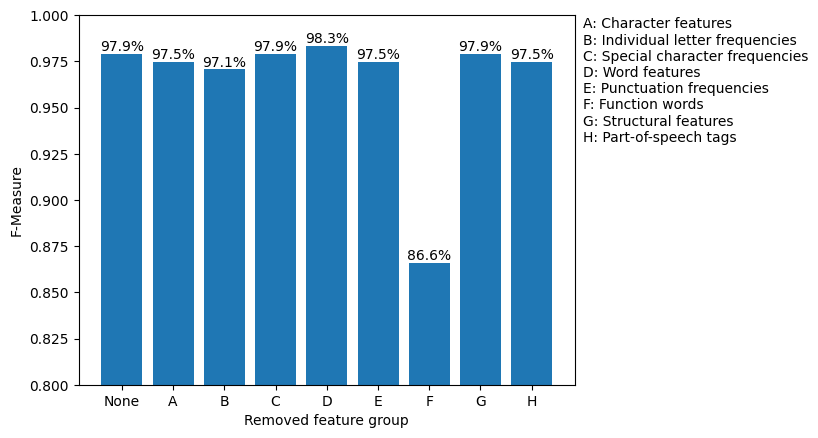

In [83]:
legend = ['A: Character features',
          'B: Individual letter frequencies', 
          'C: Special character frequencies',
          'D: Word features',
          'E: Punctuation frequencies',
          'F: Function words',
          'G: Structural features',
          'H: Part-of-speech tags']
legend = '\n'.join(legend)

fig, ax = plt.subplots()
bar_container = ax.bar(['None','A','B','C','D','E','F','G', 'H'], scores)
ax.set_ylim([0.8, 1])
ax.set_ylabel('F-Measure')
ax.set_xlabel('Removed feature group')
ax.bar_label(bar_container, fmt=lambda x: f'{x * 100:.1f}%')
plt.text(9,0.999, legend, va="top")

plt.show()

In [85]:

def test_accuracy(X_test, y_test):
  return model.score(X_test, y_test)

test_acc = test_accuracy(X_test_scaler, y_test)
print("Test accuracy: %.1f" % (test_acc *100) + "%")

Test accuracy: 97.5%
